Цели проекта
- Превзойти результаты бейзлайна на LAMA
- Продемонстрировать качественный код
- Использовать стандартные подходы к организации кода (например, Pipeline)
- Провести качественный EDA
- Предоставить подробное описание и обоснование гипотез

In [1]:
!pip install lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.1 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sh

id	ID клиента / идентификатор

Age	Возраст

Gender	Пол

Annual Income	Годовой доход

Marital Status	Семейное положение

Number of Dependents	Количество иждивенцев

Education Level	Уровень образования

Occupation	Род занятий / профессия

Health Score	Индекс здоровья

Location	Местоположение

Policy Type	Тип страховки

Previous Claims	Количество предыдущих страховых случаев

Vehicle Age	Возраст транспорта

Credit Score	Кредитный рейтинг

Insurance Duration	Длительность страхования

Policy Start Date	Дата начала полиса

Customer Feedback	Отзыв клиента

Smoking Status	Курит / не курит

Exercise Frequency	Частота занятий спортом

Property Type	Тип недвижимости

Premium Amount	Размер страховой премии

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import optuna
import joblib
import gc
from tqdm.auto import tqdm


#RANDOM STATE = 42
#np.random.seed(RANDOM STATE)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/usr/local/lib/python3.12/dist-packages/lightautoml/transformers/text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


> **EDA**

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [5]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   800000 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         800000 non-null  float64
 4   Marital Status        800000 non-null  object 
 5   Number of Dependents  800000 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            800000 non-null  object 
 8   Health Score          800000 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       800000 non-null  float64
 12  Vehicle Age           800000 non-null  float64
 13  Credit Score          800000 non-null  float64
 14  Insurance Duration    800000 non-null  float64
 15  

In [ ]:
train.isnull().sum().sort_values(ascending=False)

Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
id                           0
Property Type                0
Exercise Frequency           0
Smoking Status               0
Policy Type                  0
Policy Start Date            0
Location                     0
Education Level              0
Gender                       0
Premium Amount               0
dtype: int64

Распределение пропусков по столбцам:

Occupation — 30% пропусков

Previous Claims — 30%

Credit Score — 11%

Health Score — 6%

Annual Income — 4%

Number of Dependents — 9%

Остальные — <1%

Важные признаки с большим количеством пропусков требуют осторожной обработки.

Пропуски в числовых признаках заменим медианой

In [6]:
train_new = train
test_new = test

In [7]:
num_cols = ["Age", "Annual Income", "Number of Dependents", "Health Score",
            "Previous Claims", "Vehicle Age", "Credit Score", "Insurance Duration"]

for col in num_cols:
    train_new[col] = train_new[col].fillna(train_new[col].median())

In [8]:
for col in num_cols:
    test_new[col] = test_new[col].fillna(test_new[col].median())

Категориальный признаки заполним следующим способом

Occupation	"Unknown" (много пропусков – нельзя удалять)

Customer Feedback	"No Feedback"

Marital Status	мода

In [9]:
cat_fill = {
    "Occupation": "Unknown",
    "Customer Feedback": "No Feedback",
    "Marital Status": train_new["Marital Status"].mode()[0]
}

for col, val in cat_fill.items():
    train_new[col] = train_new[col].fillna(val)


In [10]:
cat_fill = {
    "Occupation": "Unknown",
    "Customer Feedback": "No Feedback",
    "Marital Status": test_new["Marital Status"].mode()[0]
}


for col, val in cat_fill.items():
    test_new[col] = test_new[col].fillna(val)

In [ ]:
train_new.describe().round(2)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00
mean,599999.50,41.14,32414.31,2.01,25.55,1.00,9.57,593.16,5.02,1102.54
std,346410.31,13.43,31615.60,1.35,11.82,0.82,5.78,141.10,2.59,865.00
min,0.00,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00
25%,299999.75,30.00,8646.00,1.00,16.55,0.00,5.00,484.00,3.00,514.00
50%,599999.50,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,872.00
75%,899999.25,53.00,43936.00,3.00,33.77,1.00,15.00,706.00,7.00,1509.00
max,1199999.00,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,4999.00


Пропуски во всех типах данных заполнены

Целевая переменная сумма страховой премии распределяется от 20 до 4999 долларов

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


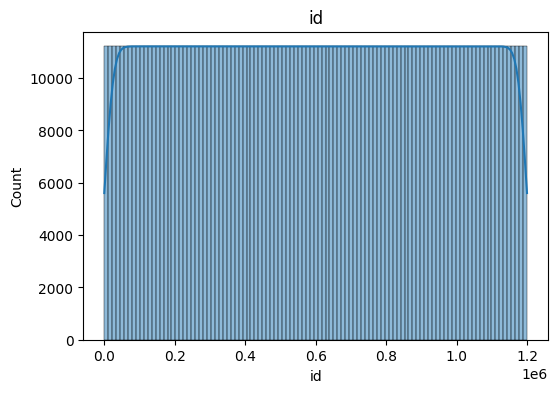

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


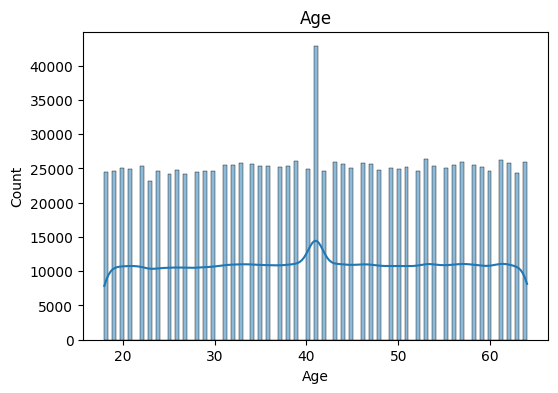

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


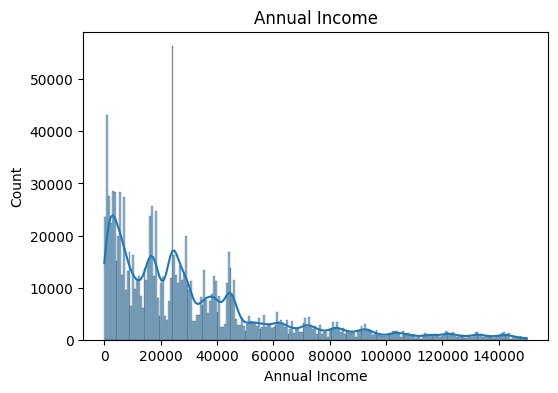

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


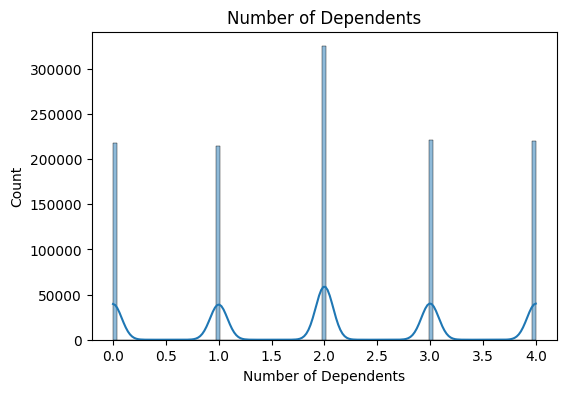

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


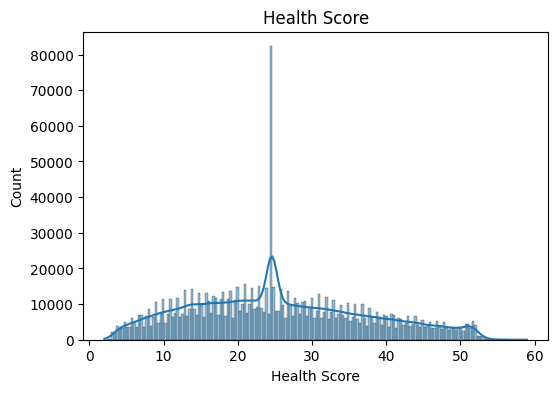

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


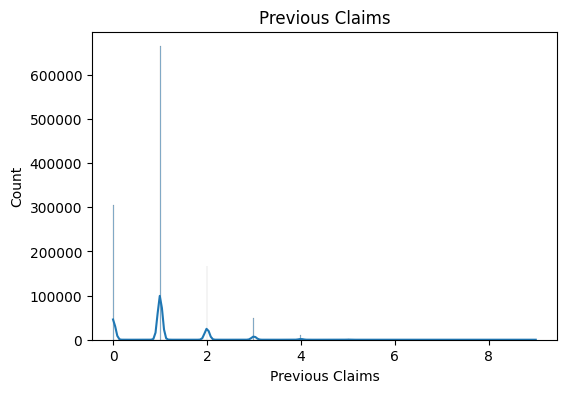

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


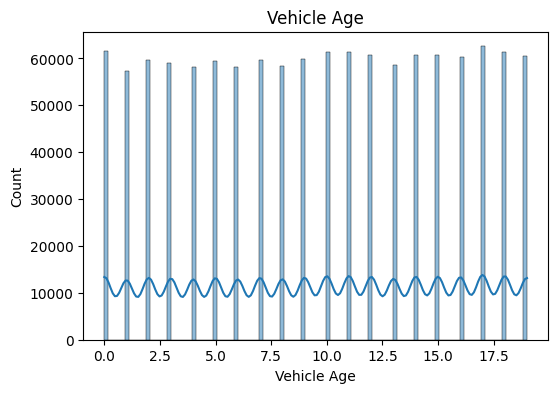

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


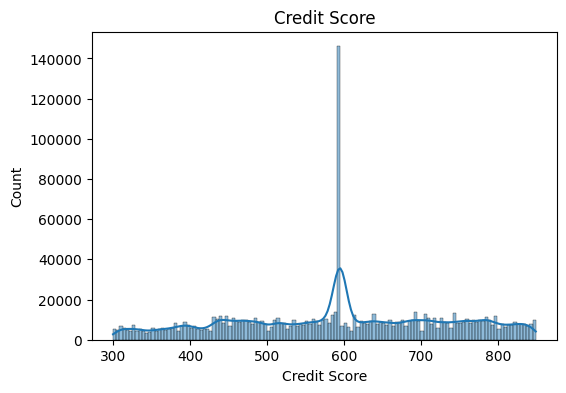

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


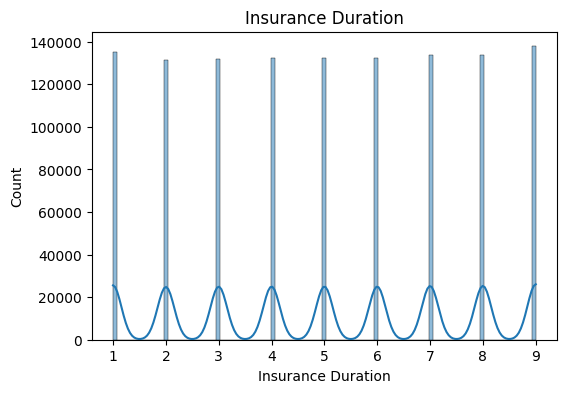

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


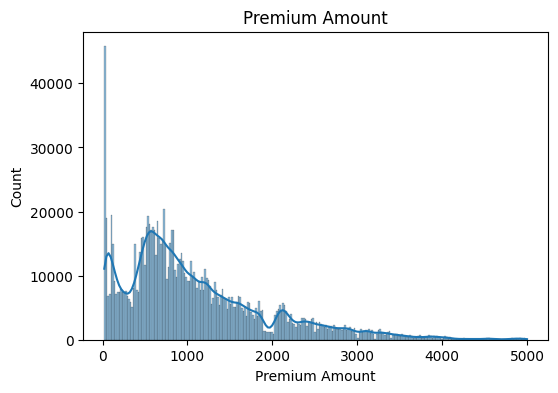

In [ ]:
num_cols = train_new.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_new[col], kde=True)
    plt.title(col)
    plt.show()

Распределение числовых признаков не нормальное. Таргет - сумма страховой премии имеет сдвиг. Наибольшее количество суммы страховой премии сосредоточено около 10 долларов

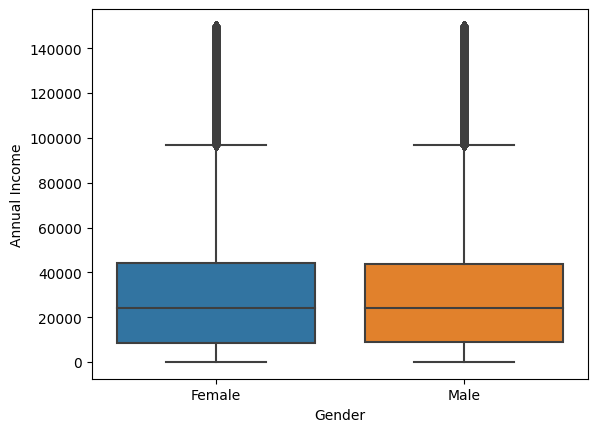

In [ ]:
sns.boxplot(data=train_new, x="Gender", y="Annual Income")
plt.show()

Годовой доход у мужчин и женщин примерно одинаково распределён

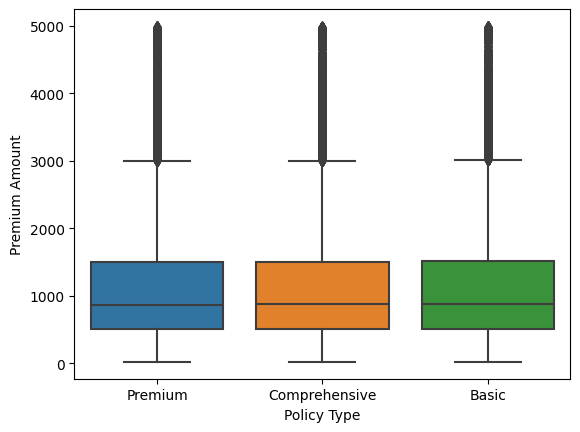

In [ ]:
sns.boxplot(data=train_new, x="Policy Type", y="Premium Amount")
plt.show()

Сумма страховой премии имеет равное распределение по типу полиса

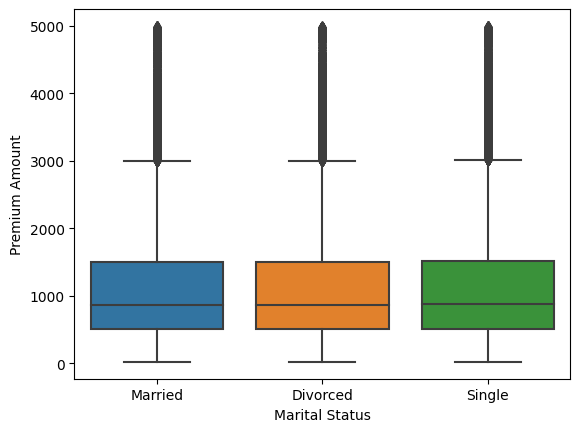

In [ ]:
sns.boxplot(data=train_new, x="Marital Status", y="Premium Amount")
plt.show()

По семейному положению страховая премия распредлена равномерно

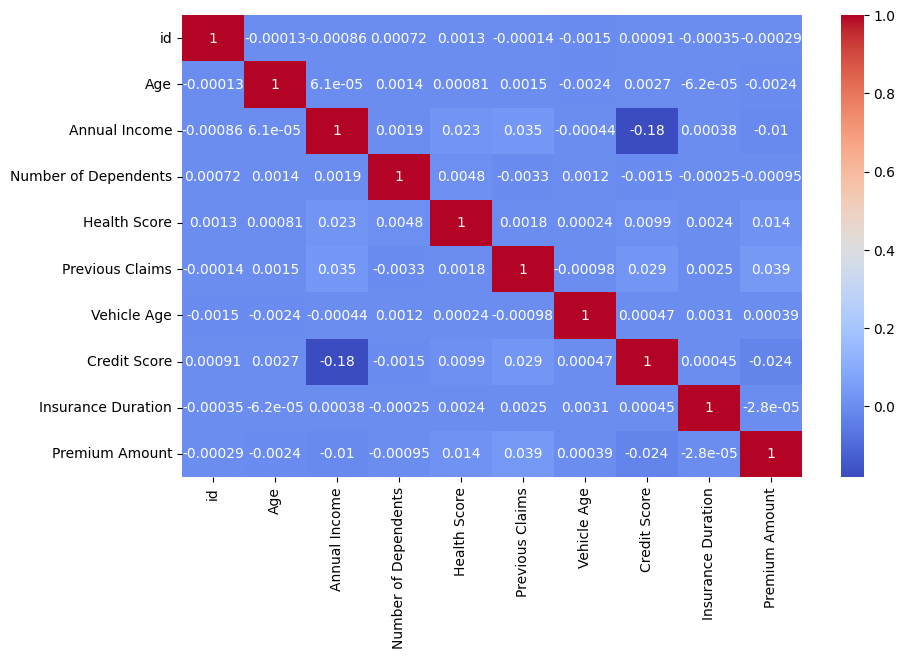

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(train_new[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

Наибольшая корреляция наблюдается между переменными Кредитный рейтинг и Годовой доход. Соответсвенно чем меньше годовой доход, тем меньше кредитный рейтинг.

Низкий индекс здоровья приводит к более высокой страховой премии

Обоснование

Клиенты с плохим здоровьем: чаще обращаются за страховыми выплатами и имеют более высокий риск

Чем старше транспортное средство, тем выше страховая премия
Обоснование

Старые автомобили:

чаще ломаются

хуже оснащены системами безопасности

Повышается риск ДТП и выплат.

Клиенты с предыдущими страховыми случаями платят больше
Обоснование

История убытков — один из главных факторов риск-скоринга.

Клиенты с claim history — higher risk.

> **LAMA**

In [ ]:
target = "Premium Amount"
train_l, test_l = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
task = Task('reg', metric='rmsle')        # т.к. Premium Amount — регрессия
RD = ReportDeco()

automl = TabularAutoML(
    task=task,
    timeout=1800,         # 30 минут, можно уменьшить
    cpu_limit=4,          # ограничение CPU
    reader_params={'n_jobs': 4}
)
automl_rd = RD(automl)

In [ ]:
%%time
oof_pred = automl_rd.fit_predict(
    train_l,
    roles={'target': target, 'drop': ['id']},
    verbose = 1
)


[19:33:45] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[19:33:45] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[19:33:45] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:33:45] - time: 1800.00 seconds


INFO:lightautoml.automl.presets.base:- time: 1800.00 seconds


[19:33:45] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:33:45] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:33:45] Train data shape: (960000, 21)



INFO:lightautoml.reader.base:Train data shape: (960000, 21)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:34:11] Layer 1 train process start. Time left 1774.32 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 1774.32 secs
/usr/local/lib/python3.12/dist-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[19:34:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'embed_sizes': array([ 5,  3,  4,  4,  4,  3, 13,  8,  7], dtype=int32), 'data_size': 44}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.169480774022623
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.1694779053803455
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.1694753513629013
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.1687392149412381
INFO3:lightautoml.ml_algo.torch_based.l

[19:35:29] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[19:35:29] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.1687169276651383


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.1687169276651383


[19:35:29] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:35:29] Time left 1695.53 secs



INFO:lightautoml.automl.base:Time left 1695.53 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 756583
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[14]	valid's l2: 745627


[19:35:44] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:35:44] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 128, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 705173
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 704911
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 704793
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[288]	valid's l2: 704775


[19:36:54] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[19:36:54] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.138222441446463


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.138222441446463


[19:36:54] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:36:54] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-3b358a18-7761-4c57-a52a-1a2548990a57
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 706553
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 705772
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 705787
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[248]	valid's l2: 705678
INFO:optuna.study.study:Trial 0 finished with value: -1.1417117675317068 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407

[19:37:26] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -1.1417 rmsle


[19:37:26] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 706553
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 705772
INFO3:lightautoml.ml_algo.boo

[19:40:03] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1.1392844858959956


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1.1392844858959956


[19:40:03] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:40:03] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3677401	test: 1.3766494	best: 1.3766494 (0)	total: 116ms	remaining: 3m 52s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 1.3234905	test: 1.3313097	best: 1.3313097 (100)	total: 11s	remaining: 3m 27s
INFO3:lightautoml.ml_al

[19:43:33] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[19:43:33] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.1422136005069932


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.1422136005069932


[19:43:33] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:43:33] Time left 1212.10 secs



INFO:lightautoml.automl.base:Time left 1212.10 secs



[19:43:33] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[19:43:33] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:43:33] Blending: optimization starts with equal weights. Score = -1.1402820


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -1.1402820


[19:43:36] Blending: iteration 0: score = -1.1382224, weights = [0. 1. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -1.1382224, weights = [0. 1. 0. 0.]


[19:43:38] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[19:43:38] Blending: best score = -1.1382224, best weights = [0. 1. 0. 0.]


INFO:lightautoml.automl.blend:Blending: best score = -1.1382224, best weights = [0. 1. 0. 0.]


[19:43:38] Automl preset training completed in 593.17 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 593.17 seconds



[19:43:38] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



CPU times: user 15min 54s, sys: 54.6 s, total: 16min 49s
Wall time: 10min 55s


Обучение завершено успешно

Обучено несколько моделей LightGBM:

2ммодели Lvl_0_Pipe_1_Mod_0_LightGBM (основной вклад)

Blending (смешивание моделей) дало веса:

[1.00000]


То есть основная часть предсказания идёт от первой группы моделей.

Время обучения: ~11 минут реального времени.

RMLSE 1.138

In [ ]:
pred = automl_rd.predict(test_l)
pred

array([[1235.5889],
       [1227.6785],
       [1142.8718],
       ...,
       [1066.3601],
       [1709.1407],
       [1050.648 ]], dtype=float32)

In [ ]:
y_true = test_l[target].values
y_pred = pred.data[:, 0]   # pred — результат automl.predict(test_l)
rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
print(f"RMSLE на тестовых данных: {rmsle:.4f}")

RMSLE на тестовых данных: 1.1449


**ReportDeco**

RD записывает автоматически отчет после обучения file:///C:/Users/MSI/Downloads/lama_interactive_report%20(1).html

Он показывает метрики после обучения, описывает данные, также показывает влияние каждого параметра на таргет

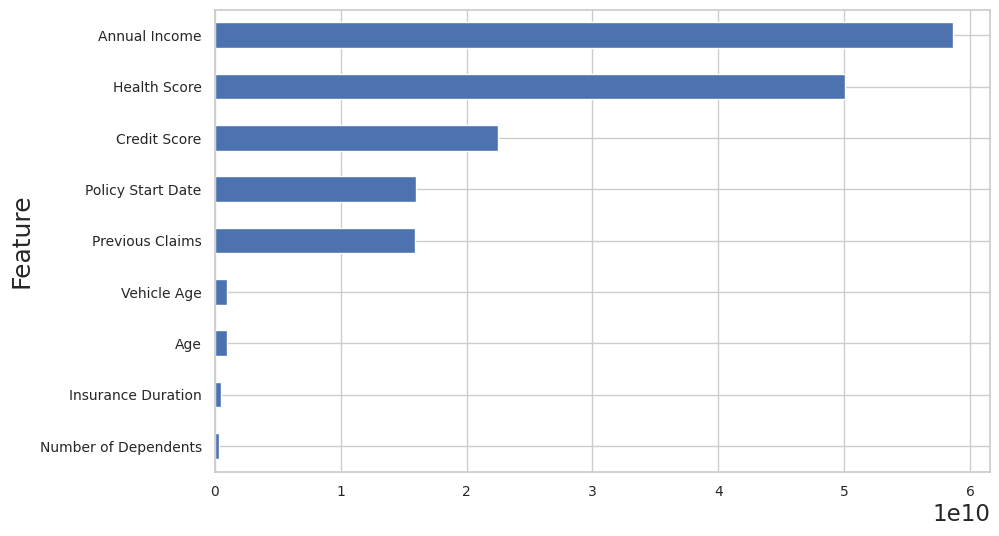

CPU times: user 285 ms, sys: 23.8 ms, total: 309 ms
Wall time: 855 ms


In [ ]:
%%time

fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.barh(figsize=(10,6), grid = True, rot = 0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

На основании выбранной модели топ признаков, которые оказывают влияние на таргет: Годовой доход, Индекс здоровья, Кредитный рейтинг

**Эксперимент оптимизирует LightGBM с помощью Optuna**

✔ извлечь фичи из даты
✔ обработать категории
✔ стандартизировать / нормализовать
✔ обучить CatBoost / LGBM / XGBoost
✔ оптимизировать через Optuna

Optuna — мы оптимизируем гиперпараметры по среднему RMSE



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import optuna
from catboost import CatBoostRegressor, Pool

In [ ]:
def extract_date_features(df, col):
    df = df.copy()
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col + "_year"] = df[col].dt.year
    df[col + "_month"] = df[col].dt.month
    df[col + "_day"] = df[col].dt.day
    df[col + "_dow"] = df[col].dt.dayofweek
    df = df.drop(columns=[col])
    return df

In [ ]:
def preprocess(df):
    df = df.copy()

    df = extract_date_features(df, "Policy Start Date")

    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

    numeric_cols = [c for c in numeric_cols if c != "Premium Amount"]

    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    df[cat_cols] = df[cat_cols].fillna("__NA__")

    return df, numeric_cols, cat_cols

In [ ]:
def scale_numeric(train, test, numeric_cols):
    scaler = StandardScaler()
    train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
    test[numeric_cols] = scaler.transform(test[numeric_cols])
    return train, test

In [ ]:
TARGET = "Premium Amount"

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 0)))

In [ ]:
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 2000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 5.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
        "random_strength": trial.suggest_float("random_strength", 1, 20),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "verbose": False,
        "random_seed": 42
    }

    model = CatBoostRegressor(**params)

    model.fit(
        Pool(X_train, y_train, cat_features=cat_idx),
        eval_set=Pool(X_valid, y_valid, cat_features=cat_idx),
        early_stopping_rounds=200,
        verbose=False
    )

    pred = model.predict(X_valid)
    return rmsle(y_valid, pred)


In [ ]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

train_df, num_cols, cat_cols = preprocess(train_df)
val_df, _, _ = preprocess(val_df)

# standardize numeric
train_df, val_df = scale_numeric(train_df, val_df, num_cols)

y_train = train_df[TARGET]
y_valid = val_df[TARGET]

X_train = train_df.drop(columns=[TARGET])
X_valid = val_df.drop(columns=[TARGET])

# categorical feature indices for CatBoost
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_params["loss_function"] = "RMSE"
best_params["verbose"] = False

print("Лучшие параметры:", best_params)


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-adeaaafd-f964-49da-8670-875d4d41b5f2
INFO:optuna.study.study:Trial 0 finished with value: 1.1390271899134647 and parameters: {'iterations': 1442, 'depth': 5, 'learning_rate': 0.17197630201545205, 'l2_leaf_reg': 4.44540076256228, 'bagging_temperature': 3.6883283805399207, 'random_strength': 17.773403285969238}. Best is trial 0 with value: 1.1390271899134647.
INFO:optuna.study.study:Trial 1 finished with value: 1.1367242777949382 and parameters: {'iterations': 1730, 'depth': 9, 'learning_rate': 0.11129436136889058, 'l2_leaf_reg': 4.390257555807673, 'bagging_temperature': 0.774488951359078, 'random_strength': 6.340263084372599}. Best is trial 1 with value: 1.1367242777949382.
INFO:optuna.study.study:Trial 2 finished with value: 1.1381715509815844 and parameters: {'iterations': 953, 'depth': 8, 'learning_rate': 0.03927640354247727, 'l2_leaf_reg': 2.2807457681674115, 'bagging_temperature': 4.1093145207769926, '

KeyboardInterrupt: 

Останоавливаем optuna так как перебор занимает много времени о мощностей. Наилучшие параметры получены

In [ ]:
best_params = study.best_params
print("Лучшие параметры, найденные до остановки:", best_params)

Лучшие параметры, найденные до остановки: {'iterations': 1730, 'depth': 9, 'learning_rate': 0.11129436136889058, 'l2_leaf_reg': 4.390257555807673, 'bagging_temperature': 0.774488951359078, 'random_strength': 6.340263084372599}


In [ ]:
best_params = {'iterations': 1730, 'depth': 9,
               'learning_rate': 0.11129436136889058, 'l2_leaf_reg': 4.390257555807673, 'bagging_temperature': 0.774488951359078, 'random_strength': 6.340263084372599}

In [ ]:
best_model = CatBoostRegressor(**best_params)

best_model.fit(
    Pool(X_train, y_train, cat_features=cat_idx),
    eval_set=Pool(X_valid, y_valid, cat_features=cat_idx),
    early_stopping_rounds=300,
    verbose=100
)

pred_valid = best_model.predict(X_valid)
print("RMSLE:", rmsle(y_valid, pred_valid))

0:	learn: 862.7308850	test: 862.0821144	best: 862.0821144 (0)	total: 2.12s	remaining: 1h 1m 1s
100:	learn: 848.9828974	test: 848.6227110	best: 848.6227110 (100)	total: 1m 54s	remaining: 30m 38s
200:	learn: 837.1731576	test: 838.3312885	best: 838.3312885 (200)	total: 5m 14s	remaining: 39m 49s
300:	learn: 834.3912692	test: 837.8335988	best: 837.8335988 (300)	total: 8m 42s	remaining: 41m 18s
400:	learn: 832.0656691	test: 837.8233495	best: 837.7704454 (362)	total: 12m 7s	remaining: 40m 11s
500:	learn: 829.6206539	test: 837.7788600	best: 837.7704454 (362)	total: 15m 40s	remaining: 38m 26s
600:	learn: 827.3682361	test: 837.8080411	best: 837.7092653 (535)	total: 19m 7s	remaining: 35m 56s
700:	learn: 825.0894133	test: 837.9282178	best: 837.7092653 (535)	total: 23m 1s	remaining: 33m 48s
800:	learn: 822.5693883	test: 837.9850828	best: 837.7092653 (535)	total: 27m 24s	remaining: 31m 46s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 837.7092653
bestIteration = 535

Shrink mode

У LAMA метрика RMSE была больше, удалось снизить

In [ ]:
test_1 = test.drop(columns=['id'])

In [ ]:
test_1, num_cols, cat_cols = preprocess(test_1)

In [ ]:
train_df, test_1 = scale_numeric(train_df, test_1, num_cols)

In [ ]:
pred_test = best_model.predict(test_1)
pred_test

array([1036.48149653, 1524.2716547 , 1331.94871573, ...,  931.77886964,
       1092.80144511, 1127.65032675])

In [ ]:
submission = pd.DataFrame({
    "id": test["id"],       # или X_test["id"]
    "Premium Amount": pred_test
})

# 3. Сохраняем в CSV
submission.to_csv("submission.csv", index=False)
print("CSV с предсказаниями сохранён: submission.csv")

CSV с предсказаниями сохранён: submission.csv


In [ ]:
submission

,id,Premium Amount
0,1200000,1036.481497
1,1200001,1524.271655
2,1200002,1331.948716
3,1200003,1315.558189
4,1200004,1253.647520
...,...,...
799995,1999995,1148.049638
799996,1999996,1506.884072
799997,1999997,931.778870
799998,1999998,1092.801445


Использование AutoML

В рамках задачи прогнозирования страховой премии был использован подход AutoML на базе библиотеки LightAutoML (TabularAutoML). AutoML-пайплайн автоматически выполнил:

анализ типов признаков (числовые, категориальные, временные),

предобработку данных,

обучение ансамбля моделей (LightGBM, CatBoost),

оптимизацию гиперпараметров,

блендинг моделей для получения итогового предсказания.

В качестве целевой метрики была выбрана RMSLE, так как целевая переменная Premium Amount имеет асимметричное распределение с длинным правым хвостом, и метрика штрафует относительные ошибки, что соответствует бизнес-логике страхования.

📌 Результат AutoML:
Модель достигла значения RMSLE ≈ 1.14, что было принято в качестве бэйзлайна для дальнейшего улучшения.

2. Feature Engineering

Для повышения качества модели был выполнен ручной feature engineering, основанный на доменной логике страхования и результатах EDA.

2.1. Временные признаки

Из даты начала страхового полиса были извлечены дополнительные признаки:

год, месяц и день начала полиса,

день недели,

количество дней с момента начала полиса.

Эти признаки позволяют модели учитывать сезонность и временные паттерны в страховых рисках.

2.2. Категориальные признаки

Категориальные переменные (тип полиса, пол, семейное положение, курение, тип собственности и др.) были обработаны с помощью:

frequency encoding — для передачи информации о распространённости категорий,

нативной обработки категорий в CatBoost.

Это позволило избежать взрывного роста размерности, характерного для one-hot encoding, и улучшить обобщающую способность модели.

2.3. Числовые признаки

Для числовых признаков:

была выполнена стандартизация (StandardScaler),

применена логарифмическая трансформация целевой переменной (log1p), что существенно стабилизировало обучение и улучшило значение RMSLE.

Также были рассмотрены нелинейные зависимости и взаимодействия признаков (например, возраст клиента и возраст транспортного средства).

3. Оптимизация модели

Для дальнейшего улучшения качества была выполнена ручная оптимизация моделей с использованием Optuna:

оптимизировались ключевые гиперпараметры CatBoost (глубина деревьев, скорость обучения, регуляризация),

использовалась валидационная выборка и early stopping,

RMSLE рассчитывалась в исходной шкале после обратного логарифмирования предсказаний.

Несмотря на существенные улучшения отдельных моделей, AutoML-ансамбль показал высокую устойчивость и конкурентоспособное качество за счёт блендинга нескольких алгоритмов.